In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import numpy as np
import munch
import yaml 

#from highres_ta.scripts import utils

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

    drop maxsampdepth

    qc, flag, error, uncert

In [56]:
def read_yaml(fname: str)-> munch.Munch:


    with open(fname) as fobj:
        config = yaml.safe_load(fobj)
        
    #config = munch.munchify(config)

    return config

In [66]:
renaming_dict = read_yaml('/home/edupuis/highres_TA/renaming_dict.yaml')
url = "https://data.up.ethz.ch/shared/OceanSODA-ETHZv2/total_alkalinity/GLODAPv2023/GLODAPv2023-raw_collocated-{y}.pq"
df = (pd.concat([pd.read_parquet(url.format(y=y)) for y in range(1982, 2022)])
        .drop(columns='maxsampdepth')
        .rename(columns = renaming_dict)
)

#  column names
cnames = df.columns.tolist()


# # print info
df.info()

# Per datasets naming dictionary

datasets_dict = read_yaml('/home/edupuis/highres_TA/per_datasets_dict.yaml')


<class 'pandas.DataFrame'>
Index: 42134 entries, 83 to 492
Data columns (total 61 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   expocode_gp            42134 non-null  str           
 1   time_gp                42134 non-null  datetime64[ns]
 2   lat_gp                 42134 non-null  float64       
 3   lon_gp                 42134 non-null  float64       
 4   bottomdepth_gp         42134 non-null  float64       
 5   depth_gp               42134 non-null  float64       
 6   temp_gp                41938 non-null  float64       
 7   salinity_gp            41650 non-null  float64       
 8   oxygen                 37673 non-null  float64       
 9   aou_gp                 37037 non-null  float64       
 10  nitrate_gp             34351 non-null  float64       
 11  nitrite                27973 non-null  float64       
 12  silicate_gp            35854 non-null  float64       
 13  phosphate_gp      

# A Simple ML regression (Geeks4geeks)

In [ ]:
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score


# # Load dataset
# df = pd.read_csv("https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv")

# # Select relevant features
# features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
# df = df[features + ['Survived']].dropna()  # Drop rows with missing values

# # Display the first few rows
# print(df.head())

# # Load dataset
# df = pd.read_csv("https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv")

# # Select relevant features
# features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
# df = df[features + ['Survived']].dropna()  # Drop rows with missing values

# # Display the first few rows
# print(df.head())

# # Define target and features
# X = df[features]
# y = df['Survived']

# # Split into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Display the shape of the data
# print(f"Training set shape: {X_train.shape}")
# print(f"Testing set shape: {X_test.shape}")

# # Define the pipeline
# pipeline = Pipeline([
#     ('preprocessor', preprocessor),  # Data transformation
#     ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))  # ML model
# ])

# # Train the model
# pipeline.fit(X_train, y_train)
# print("Model training complete!")

# # Make predictions
# y_pred = pipeline.predict(X_test)

# # Compute accuracy
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Model Accuracy: {accuracy:.2f}")

# import joblib

# # Save the trained pipeline
# joblib.dump(pipeline, 'ml_pipeline.pkl')

# # Load the model
# loaded_pipeline = joblib.load('ml_pipeline.pkl')

# # Predict using the loaded model
# sample_data = pd.DataFrame([{'Pclass': 3, 'Sex': 'male', 'Age': 25, 'SibSp': 0, 'Parch': 0, 'Fare': 7.5, 'Embarked': 'S'}])
# prediction = loaded_pipeline.predict(sample_data)
# print(f"Prediction: {'Survived' if prediction[0] == 1 else 'Did not Survive'}")

# Exploratory Data Analysis

In [ ]:
# plot all samples on a map for given variable and dataset of origin
def blank_map(projection = ccrs.PlateCarree()):
    
    fig = plt.figure(figsize=(12, 10))
    ax = plt.axes(projection=projection)
    ax.add_feature(cfeature.LAND, facecolor='white')
    ax.add_feature(cfeature.OCEAN, facecolor='white')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    
    return fig, ax

def samples_map(df: pd.DataFrame, datasets_dict: munch.Munch, ds_name: str, varname: str):
    
    fig, ax = blank_map()
    
    sc = ax.scatter(
    df[datasets_dict[ds_name].coord.lon], 
    df[datasets_dict[ds_name].coord.lat],
    c= df[varname],
    s=20,
    cmap="viridis",
    transform=ccrs.PlateCarree()
    )

    plt.colorbar(sc, ax=ax, label=varname)

    plt.show()

In [47]:
def kernel_density_plot(df, title, variables_list= [], column_start= 999 , column_end = 999):
    
    if  not variables_list:
        variables_list = df.iloc[:, column_start:column_end+1].select_dtypes(include=["int64", "float32", "float64", "datetime64[ns]"]).columns
        print(variables_list)


    #sns.set_style("darkgrid")
    sns.reset_defaults()

    plt.figure(figsize=(14, len(variables_list) * 3))
    for i, feature in enumerate(variables_list, 1):
        plt.subplot(len(variables_list), 2, i)
        sns.histplot(df[feature], kde=True)
        #plt.title(f"{feature}")
        #plt.title(f"{feature} | Skewness: {round(df[feature].skew(), 2)}")

    plt.tight_layout()
    plt.suptitle(title,fontsize=16)
    plt.subplots_adjust(top=0.95)
    plt.show()


Index(['time', 'lat', 'lon', 'bottomdepth', 'maxsampdepth', 'depth',
       'temperature', 'salinity', 'oxygen', 'aou', 'nitrate', 'nitrite',
       'silicate', 'phosphate', 'tco2', 'fco2', 'phtsinsitutp', 'talk',
       'talkf', 'talkqc'],
      dtype='str')


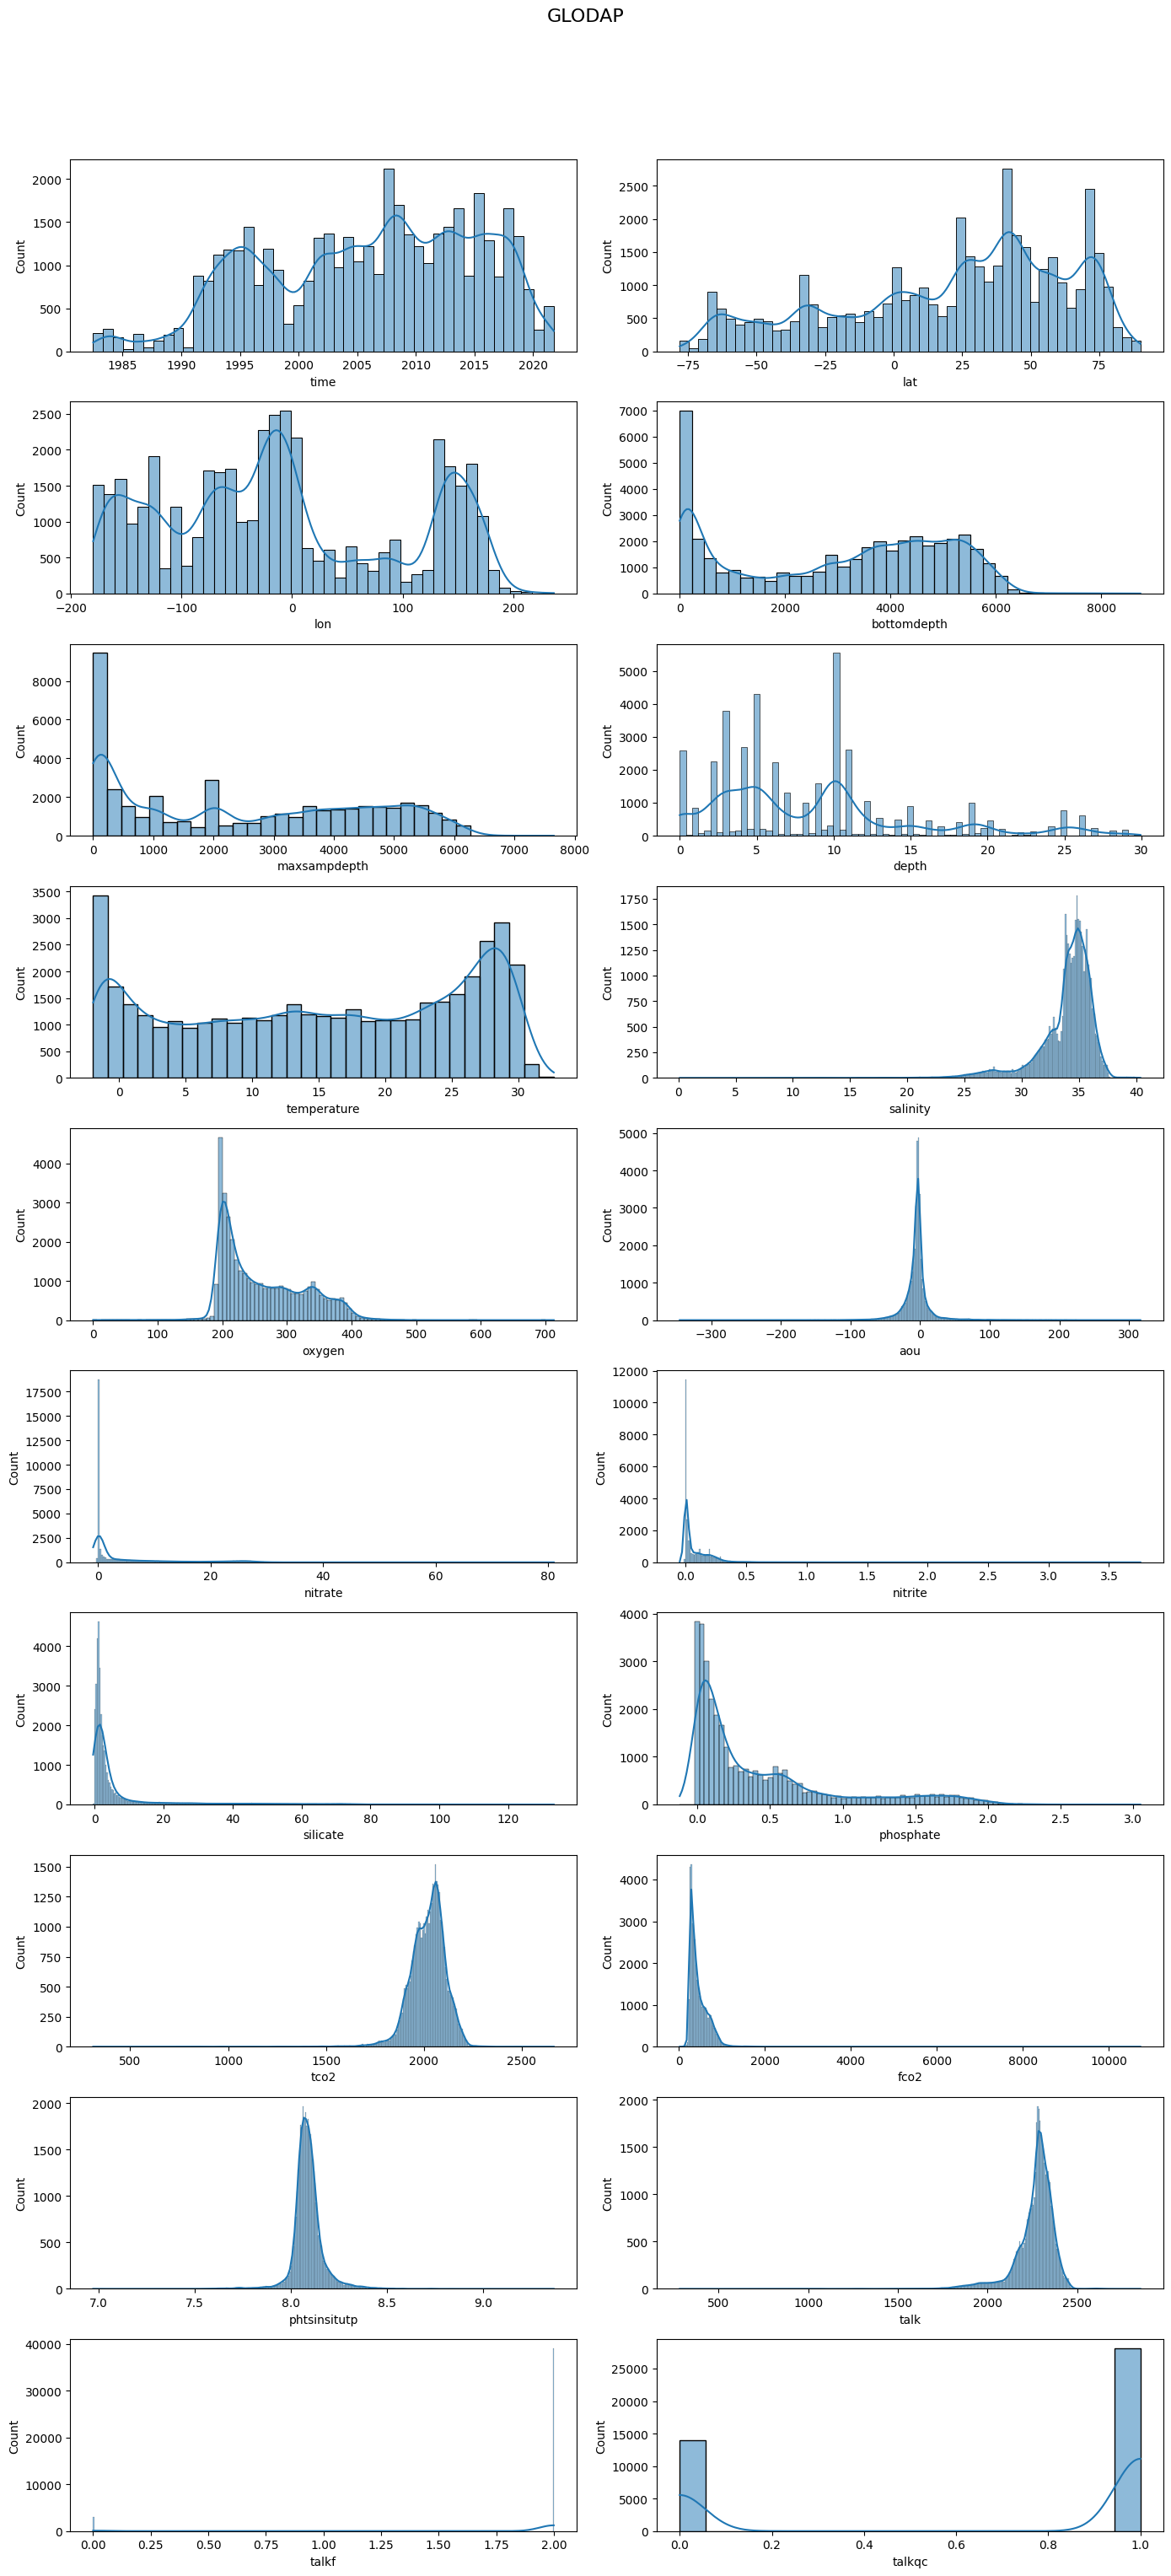

Index(['temp_soda', 'salt_soda', 'mld_dens_soda', 'lon_soda', 'lat_soda',
       'depth_soda', 'time_soda'],
      dtype='str')


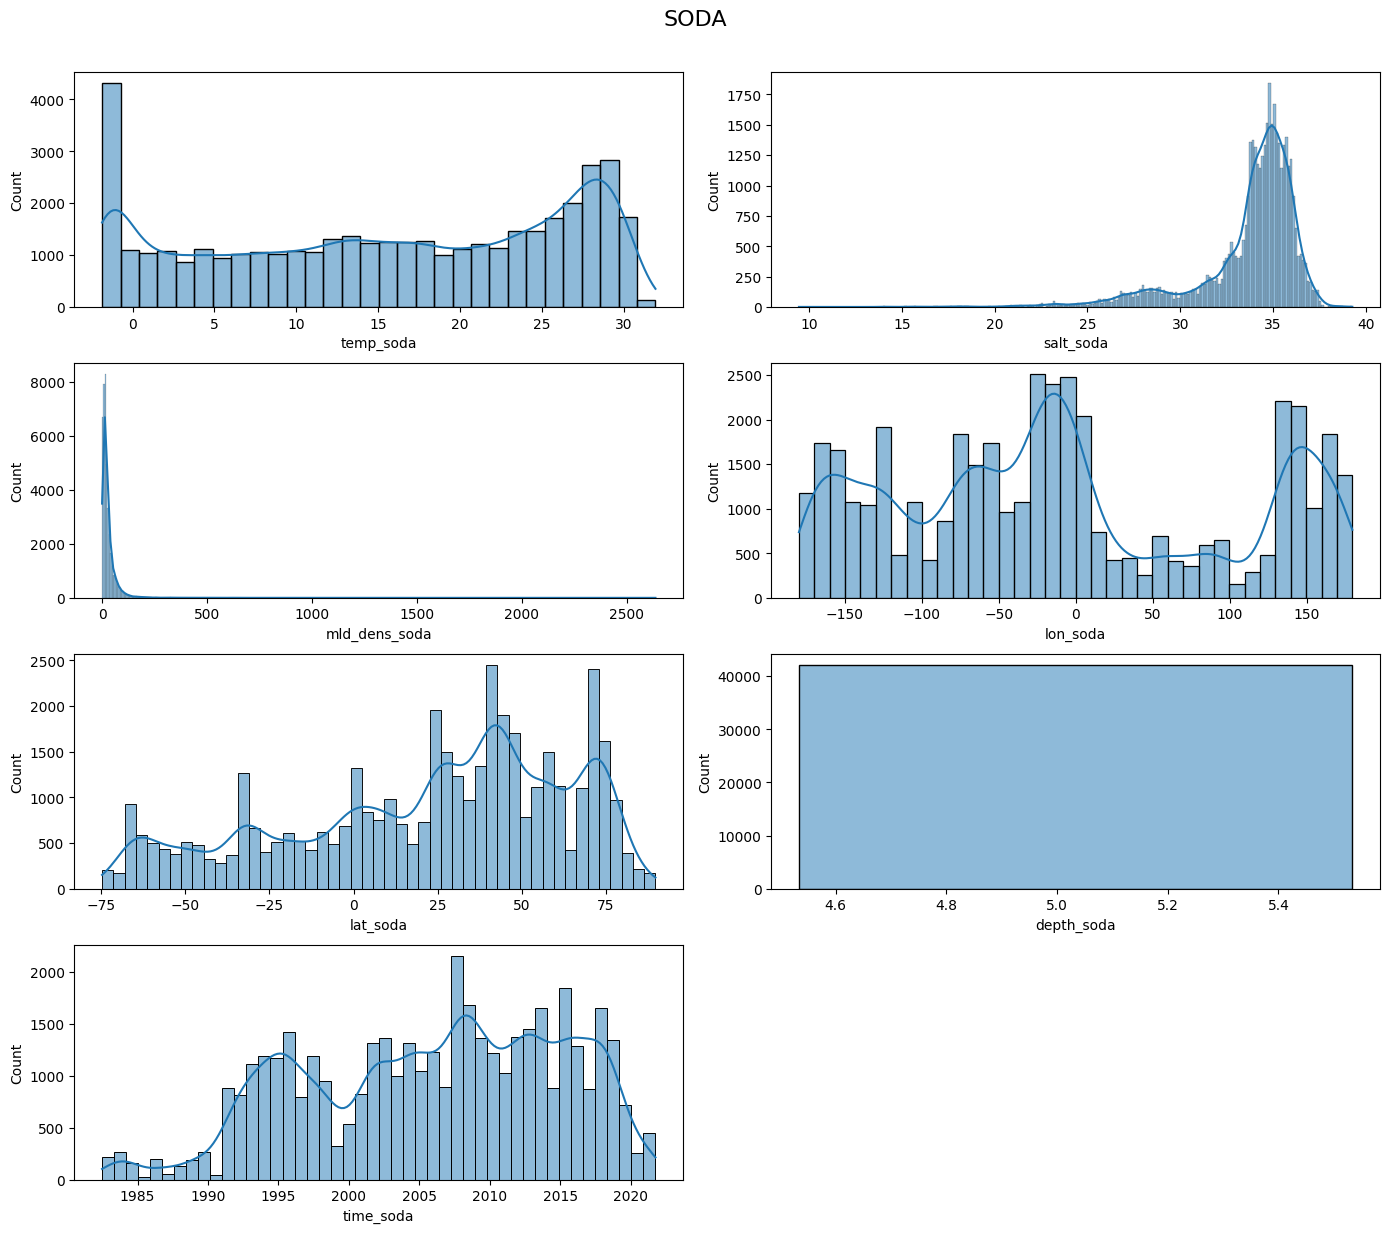

Index(['sst_cci', 'sst_cci_uncertainty', 'ice_cci', 'time_sstcci',
       'lat_sstcci', 'lon_sstcci'],
      dtype='str')


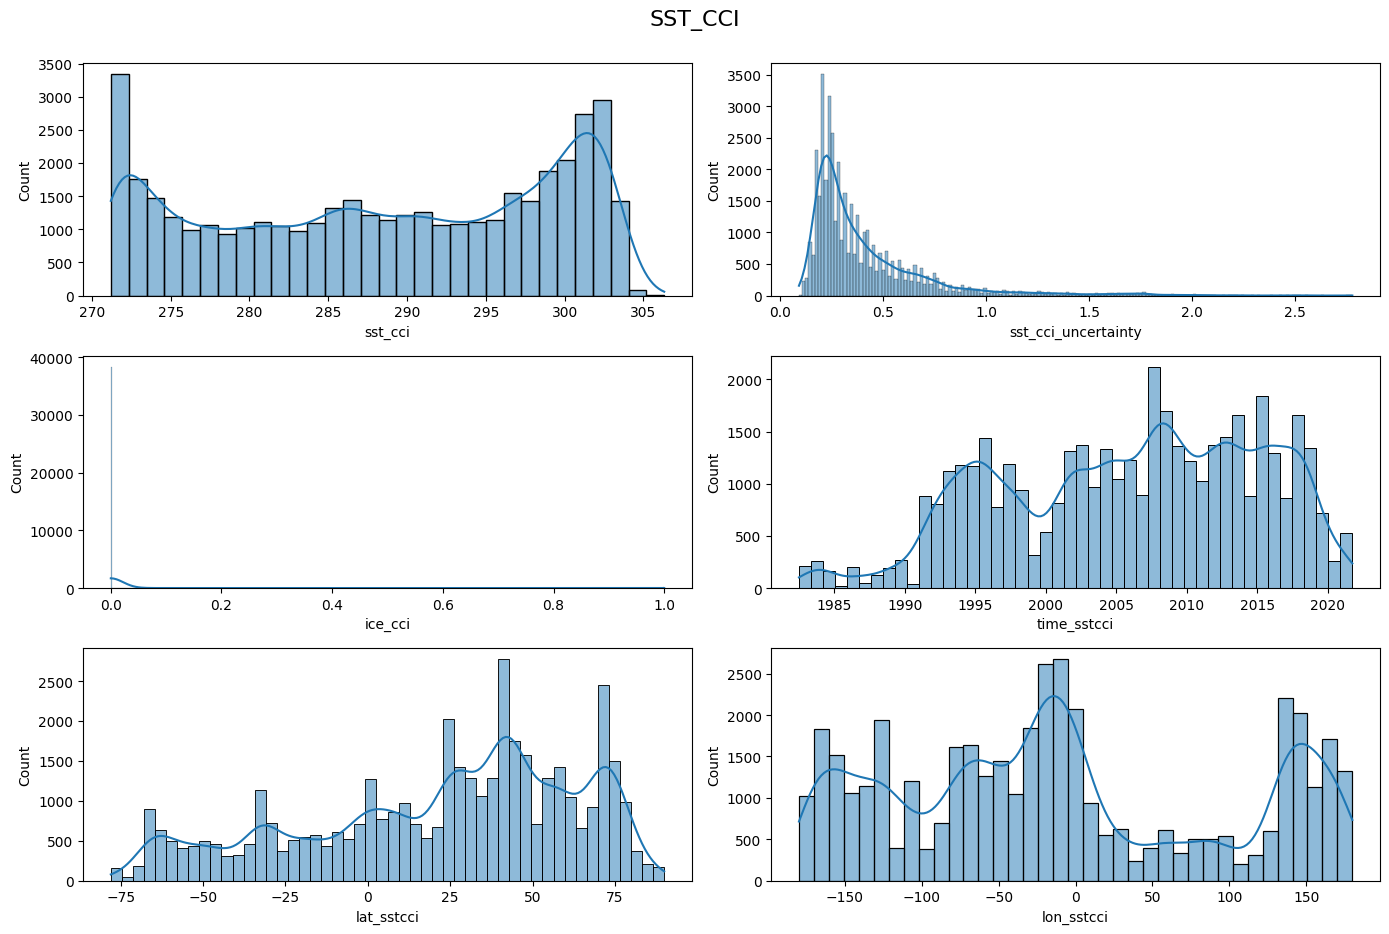

Index(['sss_cci', 'sss_cci_random_error', 'lat_ssscci', 'lon_ssscci',
       'time_ssscci'],
      dtype='str')


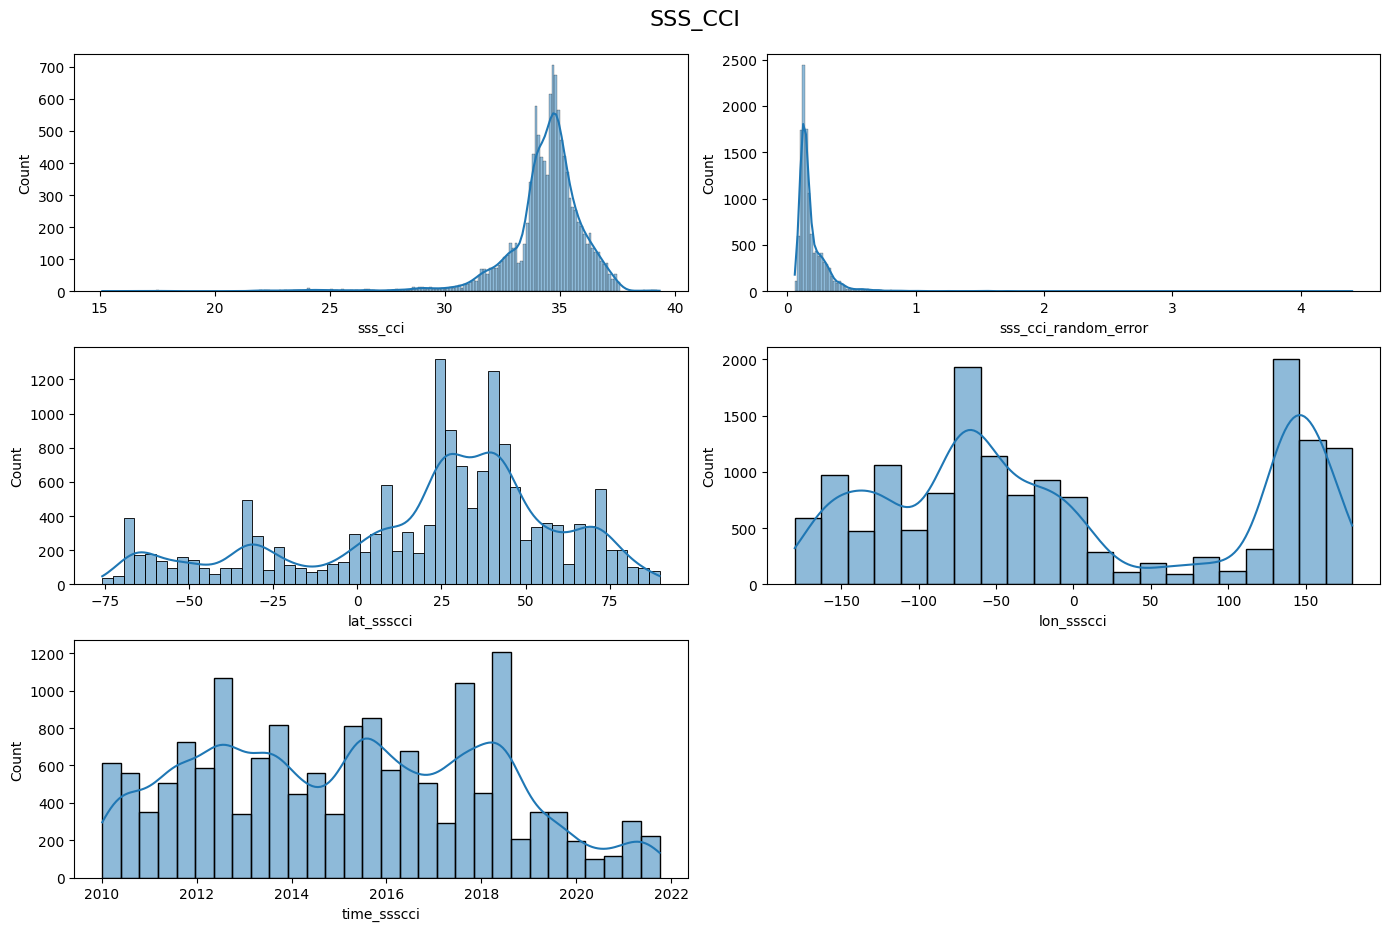

Index(['ssh_adt', 'ssh_sla', 'lat_sshcm', 'lon_sshcm', 'time_sshcm'], dtype='str')


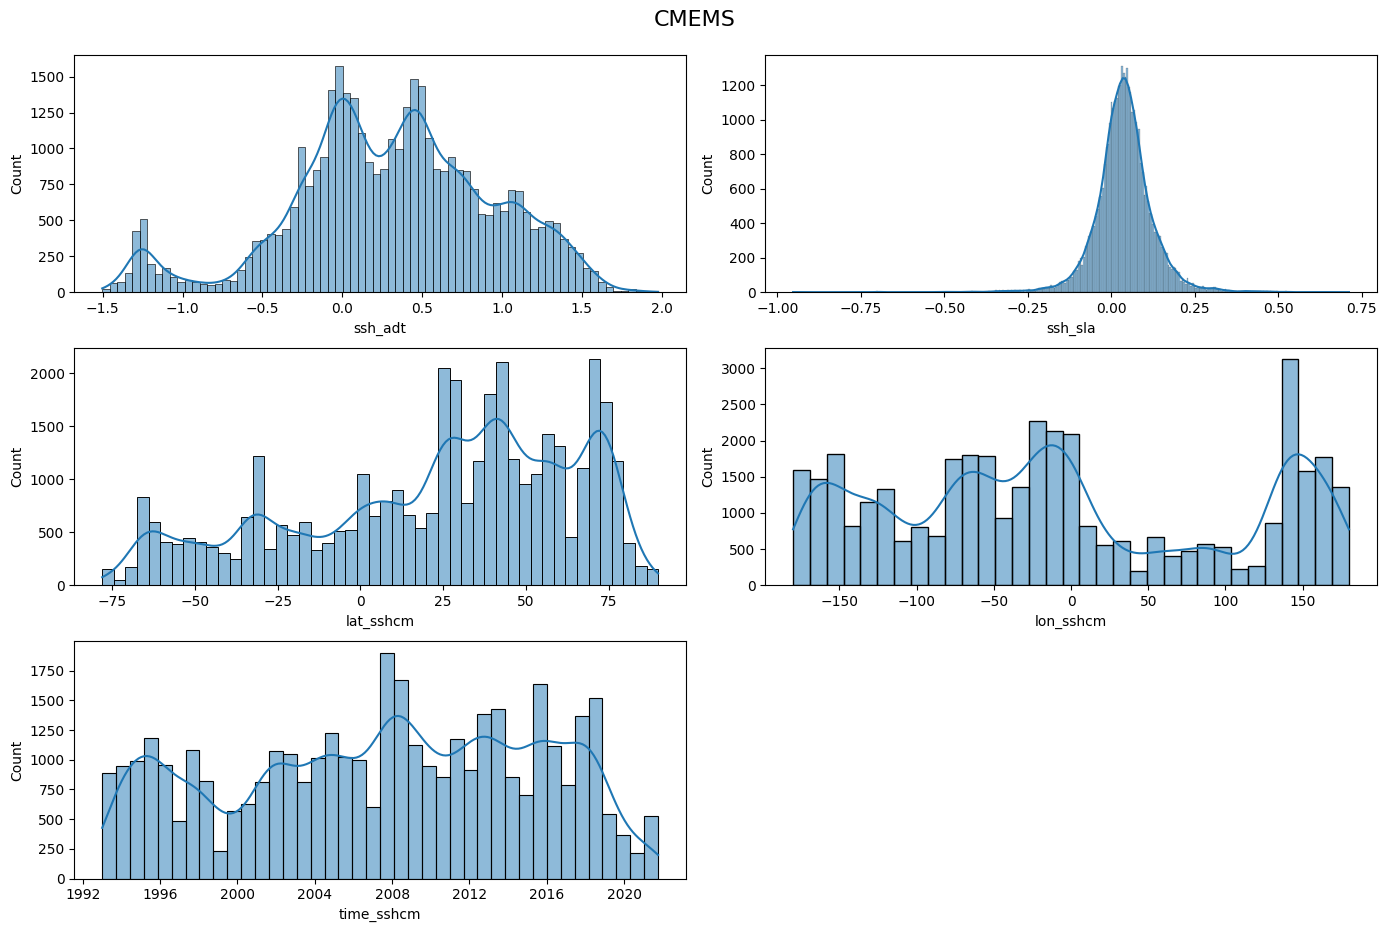

Index(['sss_glorys', 'mld_glorys', 'lat_sssglorys', 'lon_sssglorys',
       'time_sssglorys'],
      dtype='str')


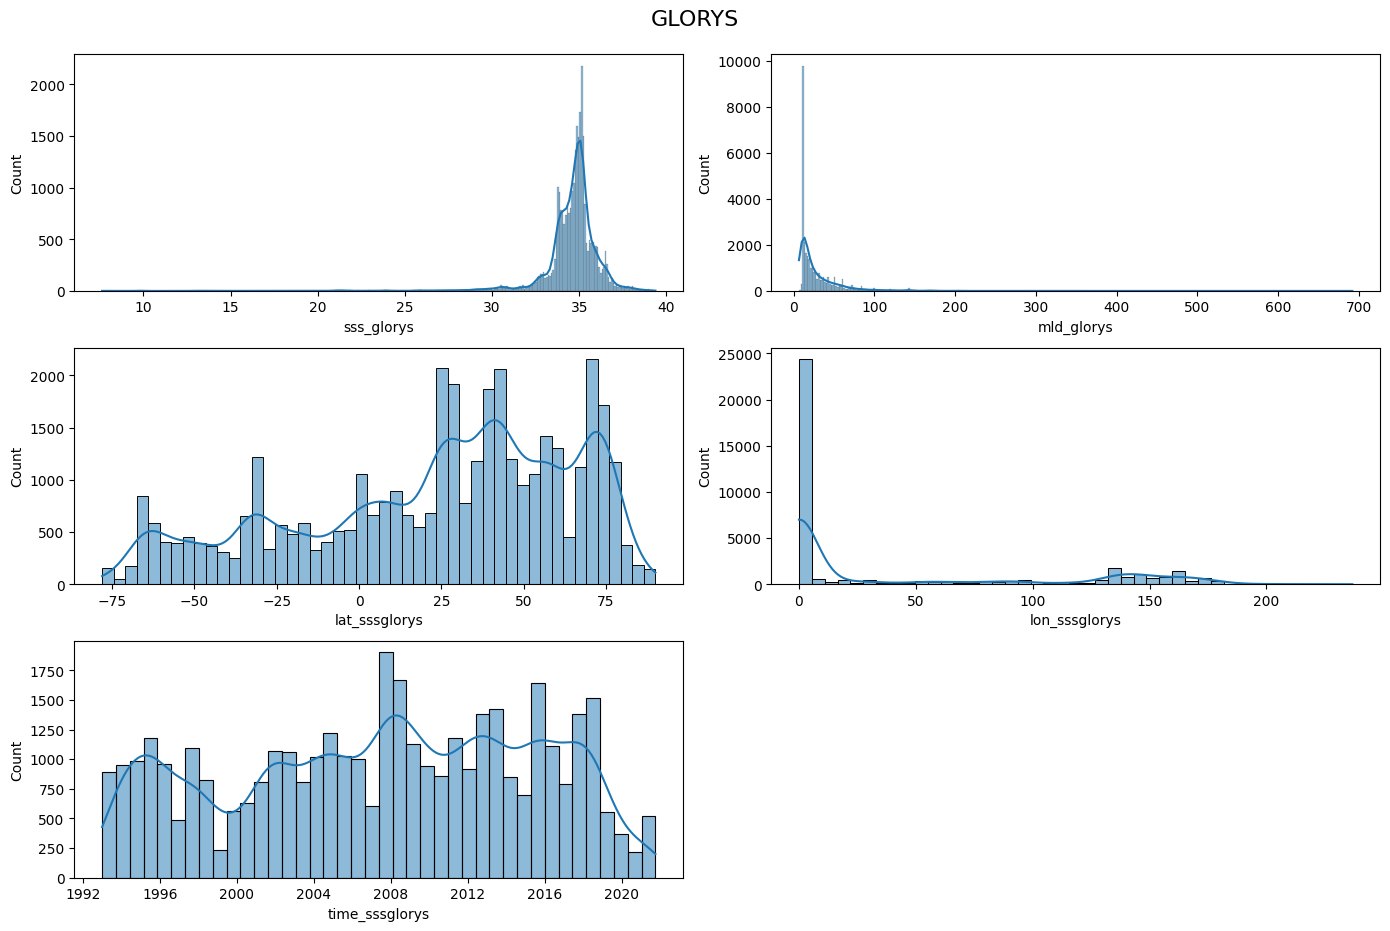

Index(['sss_multiobs', 'sss_multiobs_error', 'depth_sssmult', 'lat_sssmult',
       'lon_sssmult'],
      dtype='str')


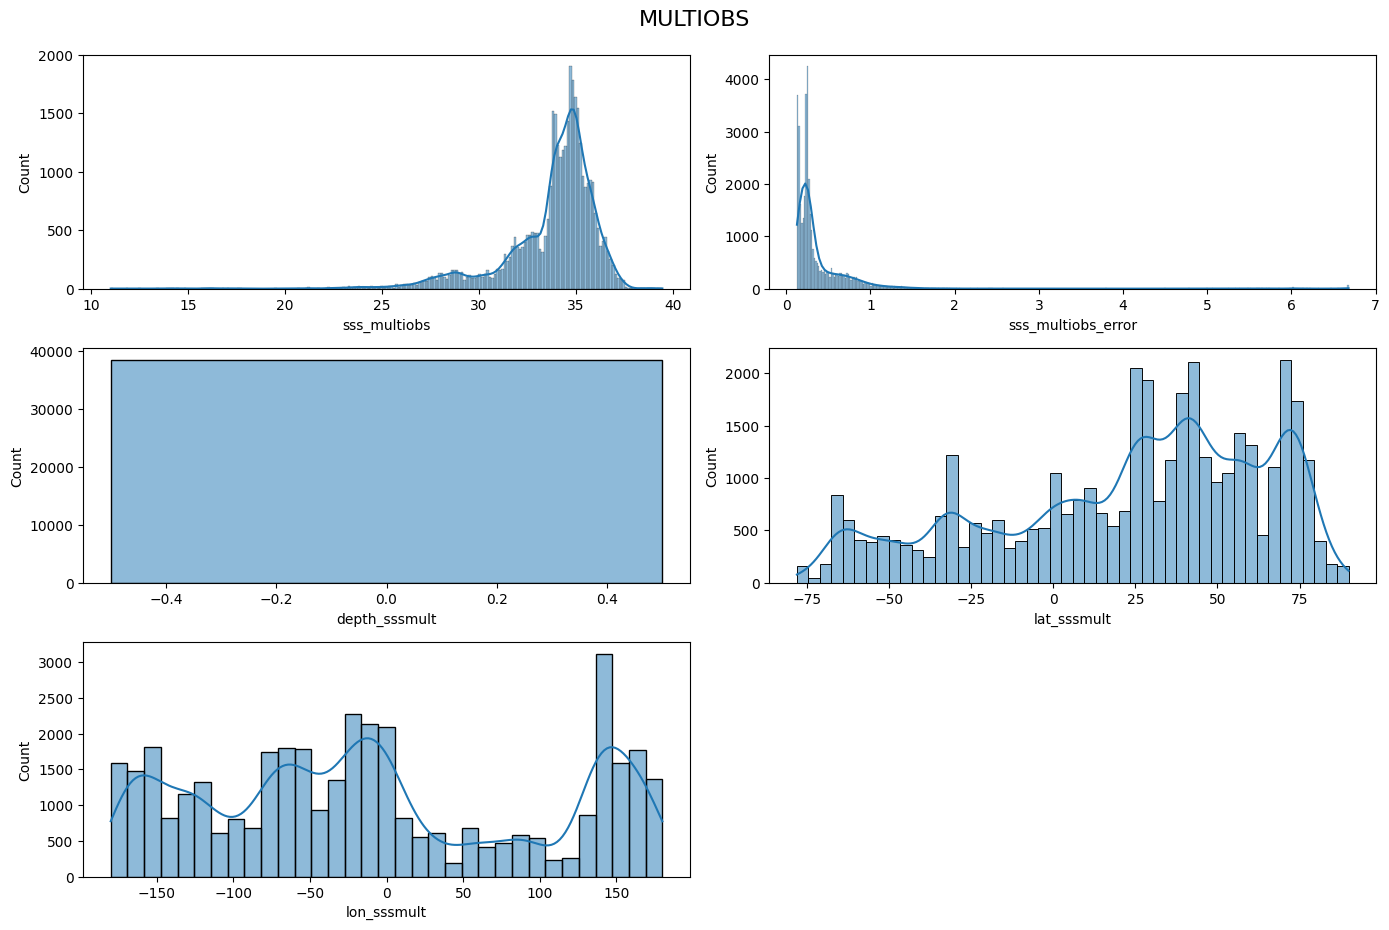

Index(['time_sssmult', 'chl_globcolour', 'chl_globcolour_uncert',
       'chl_globcolour_flags', 'time_chlgc', 'lat_chlgc', 'lon_chlgc'],
      dtype='str')


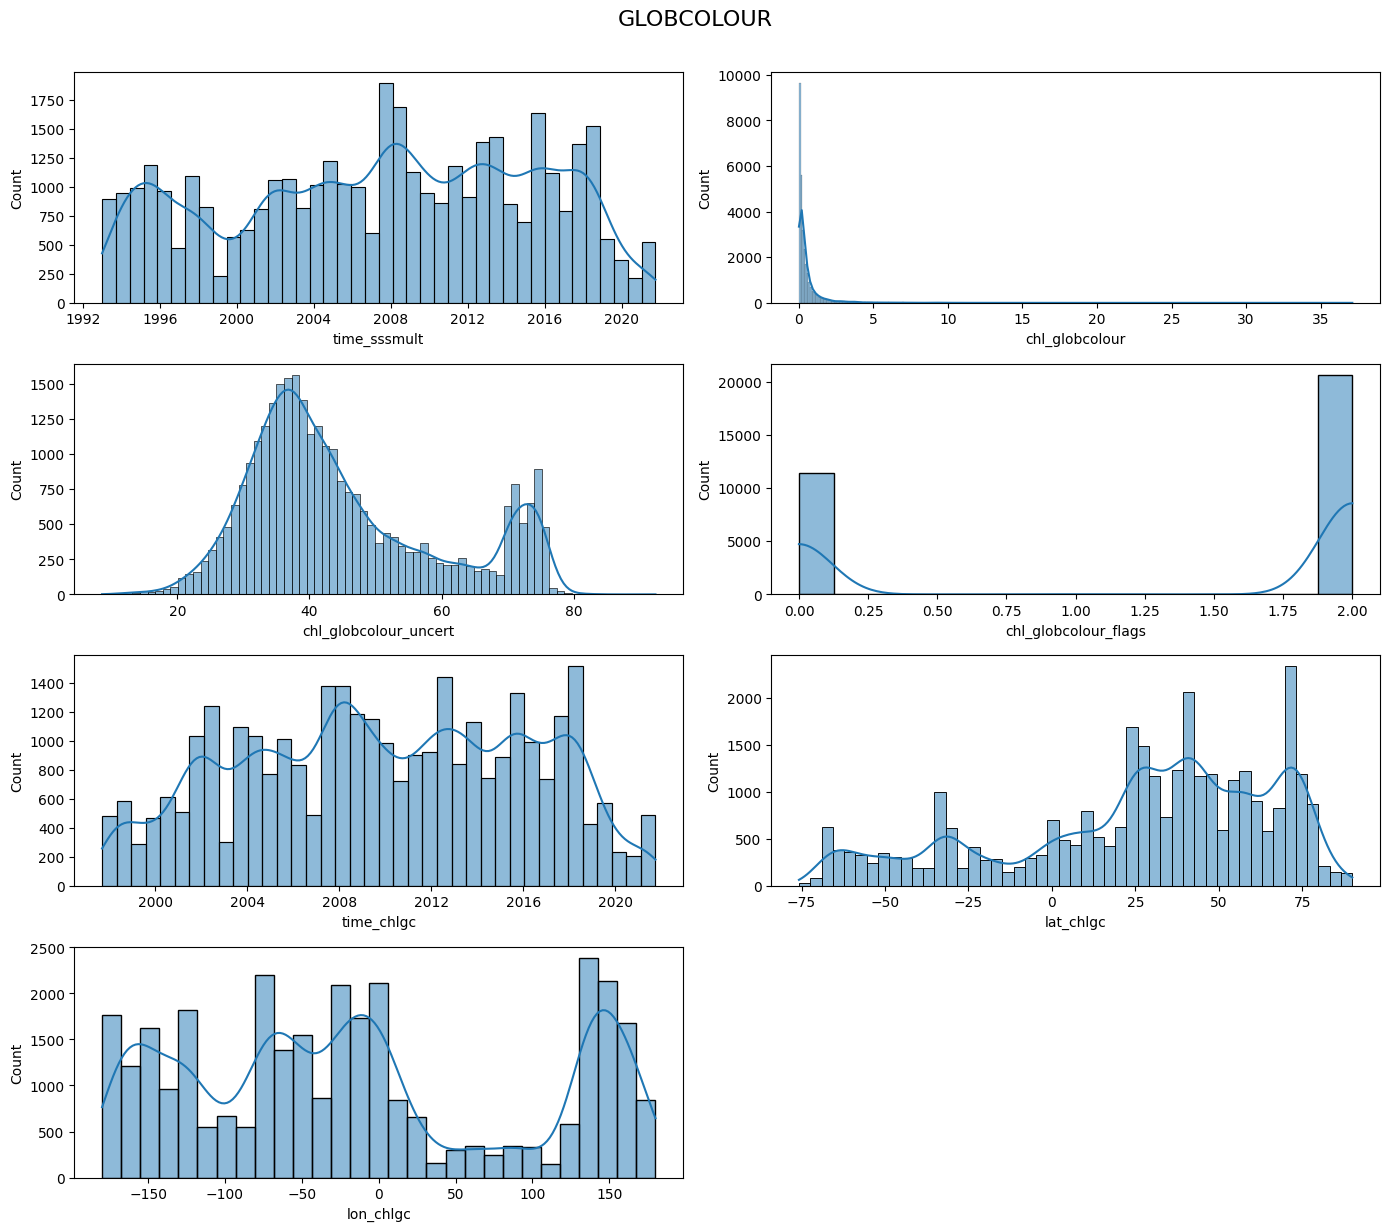

In [52]:
for ds_name in datasets_dict:
        kernel_density_plot(df, title = ds_name, column_start= datasets_dict[ds_name].columns.start , column_end= datasets_dict[ds_name].columns.end)


In [ ]:
kernel_density_plot(df,['temperature','temp_soda'])

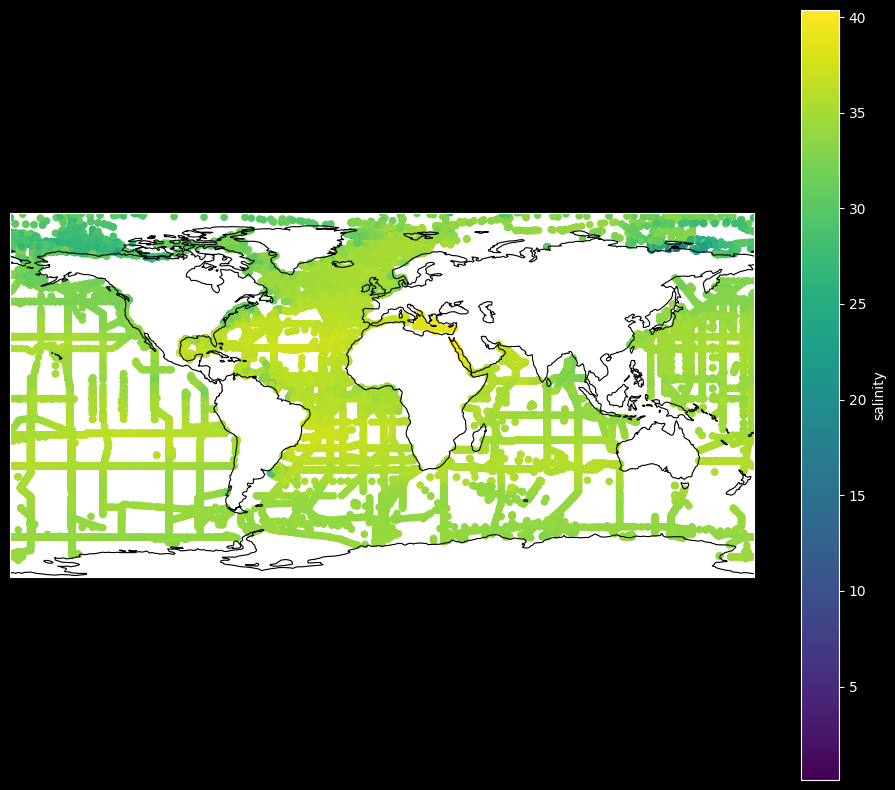

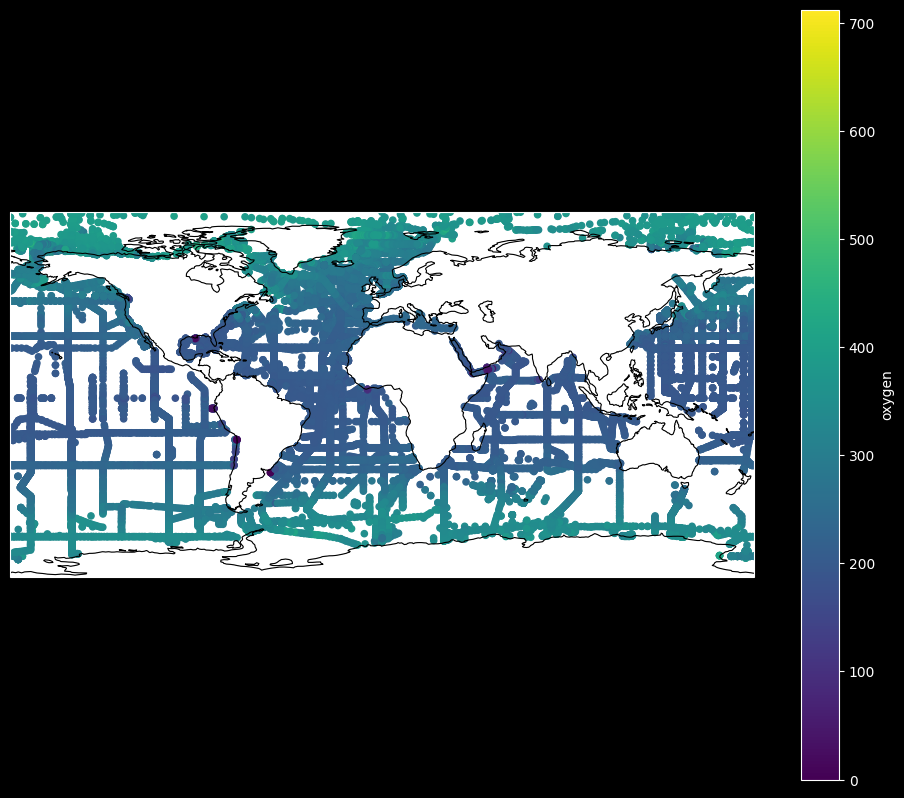

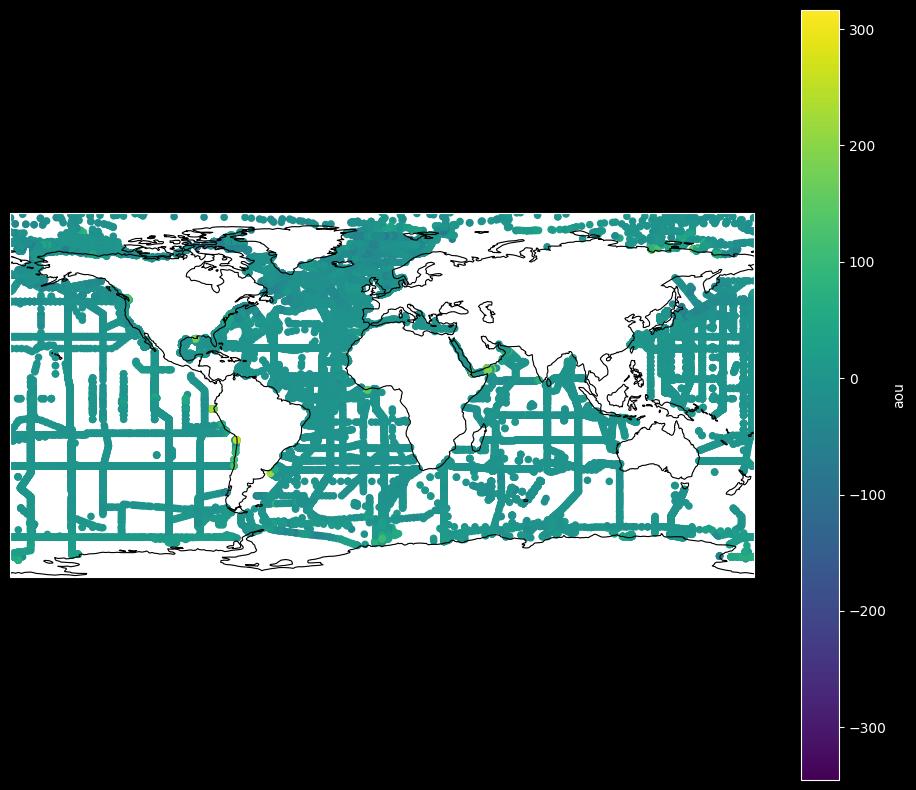

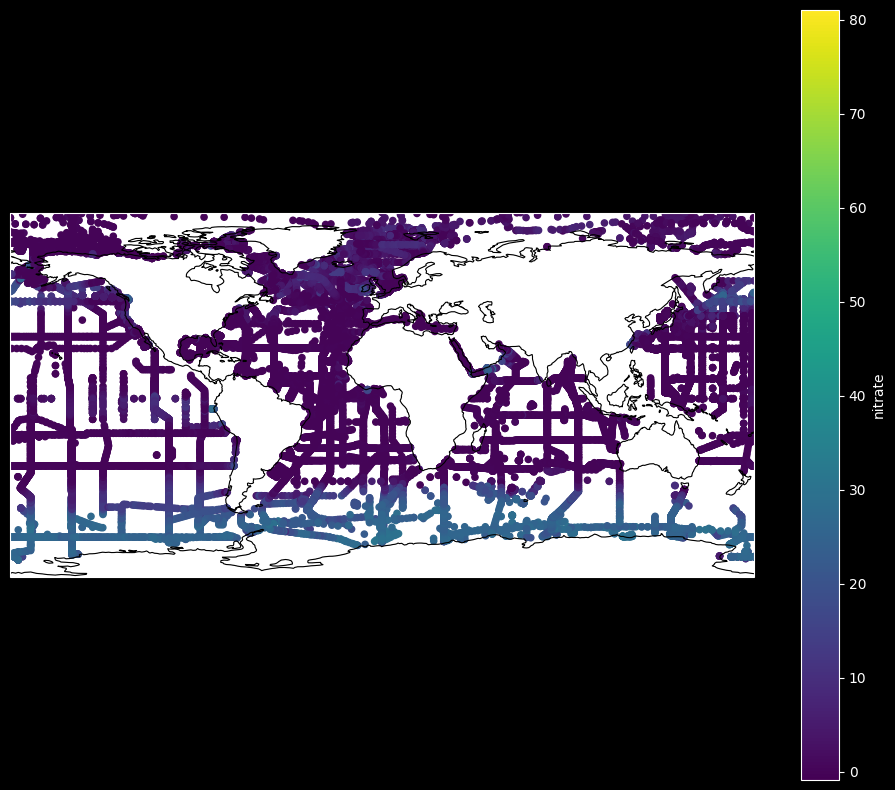

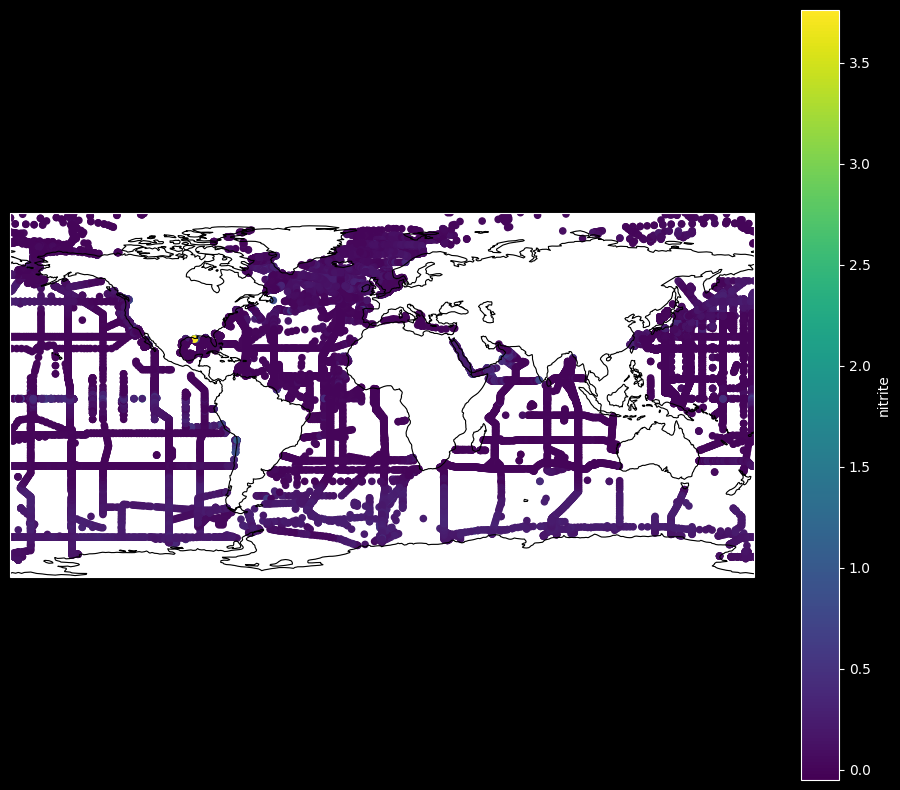

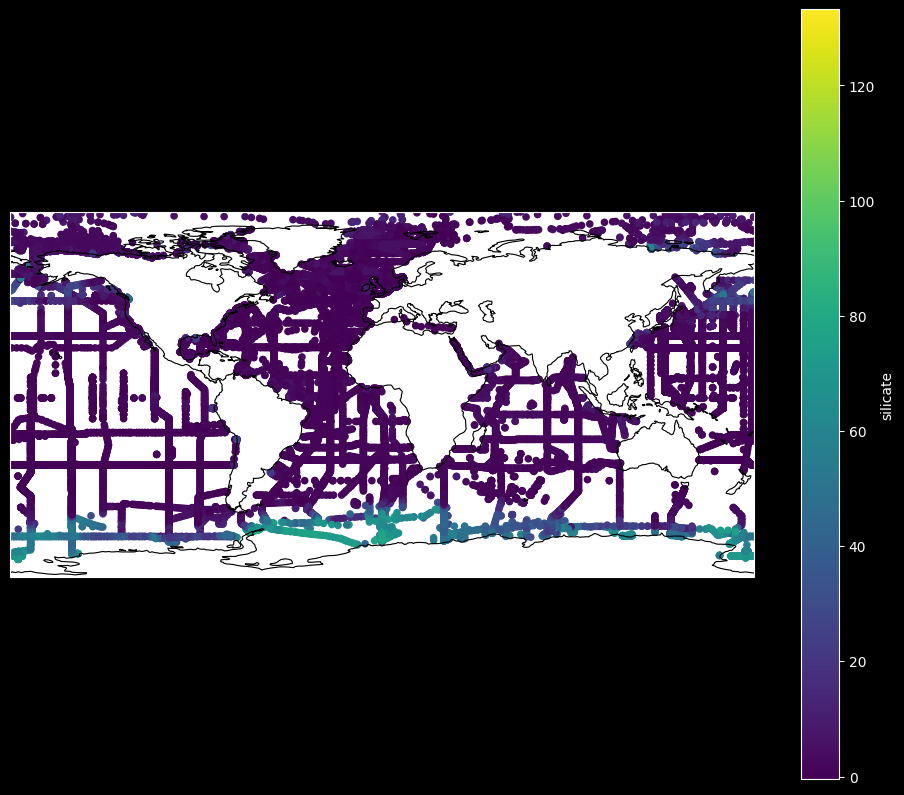

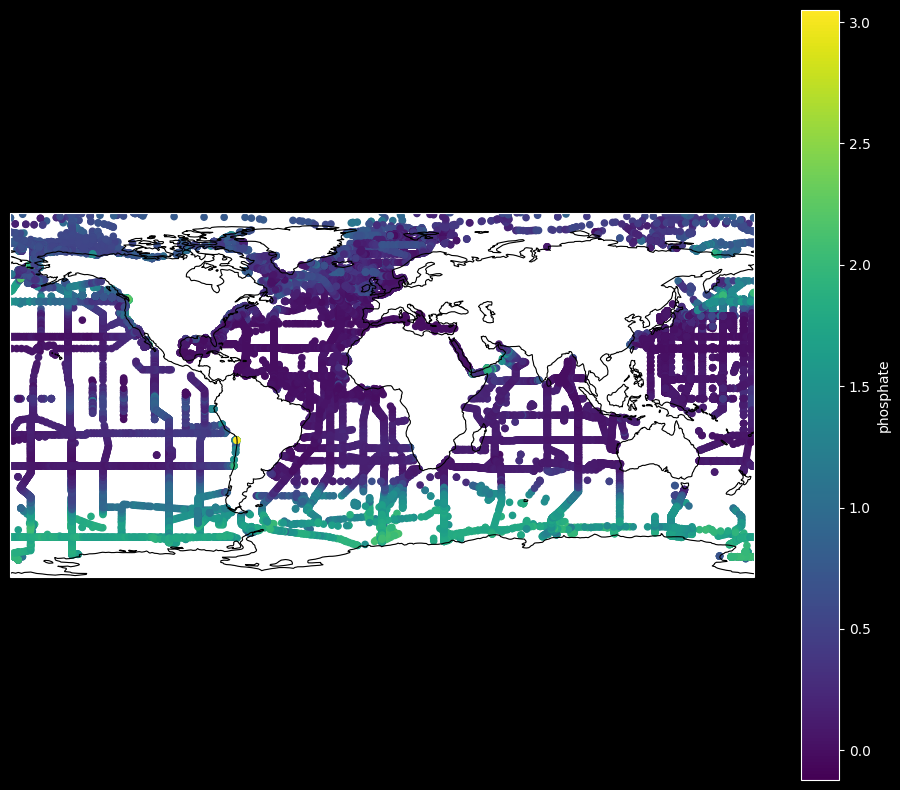

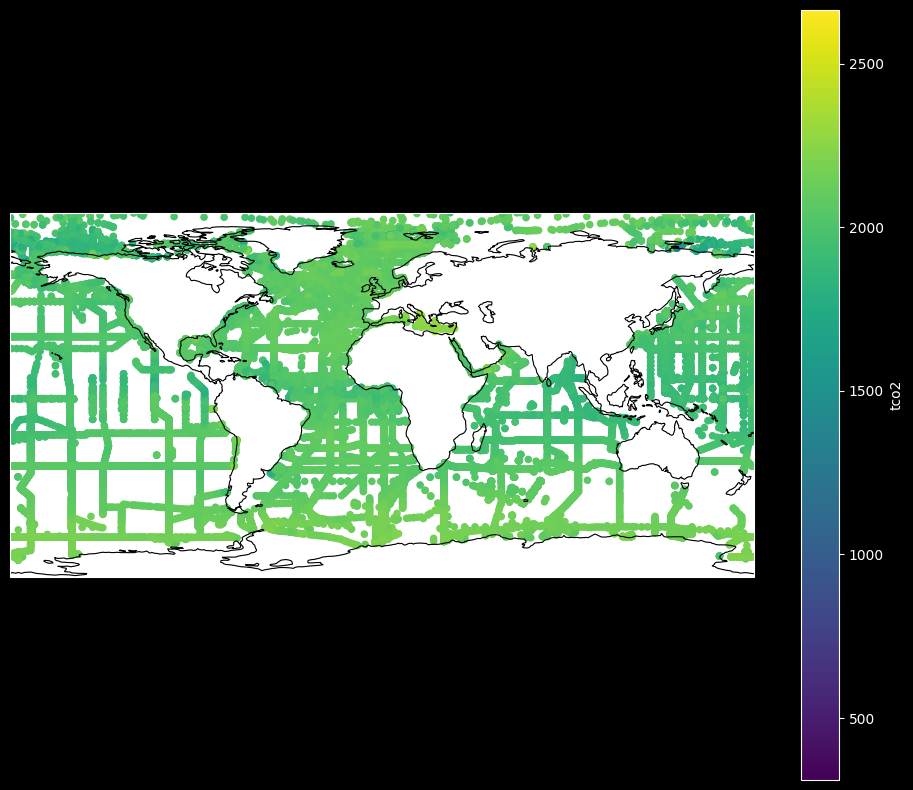

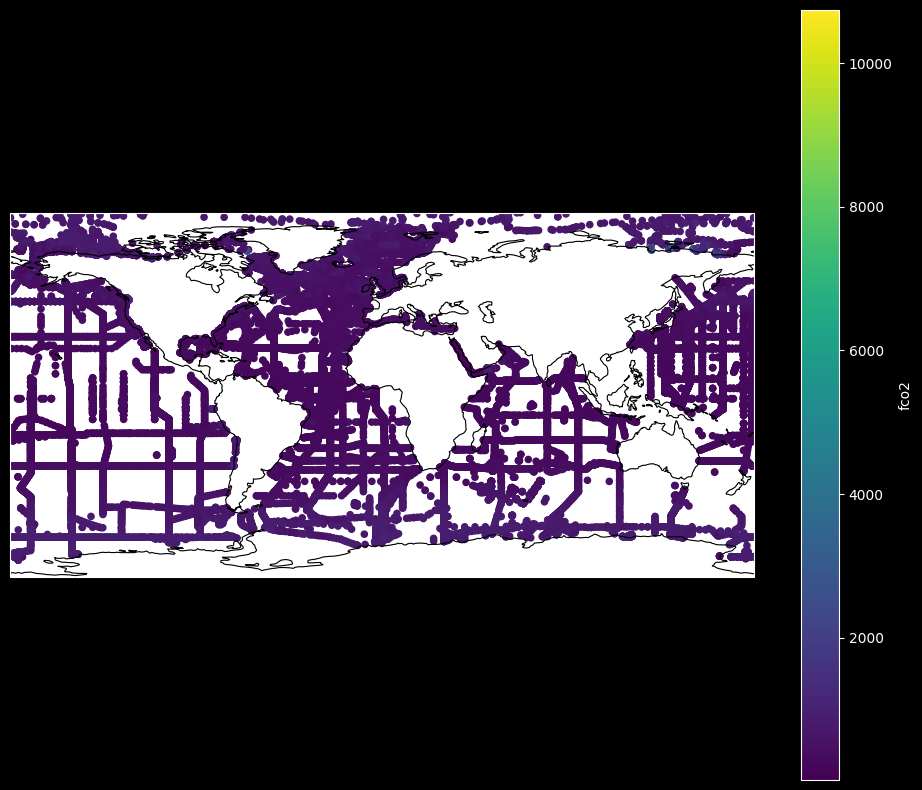

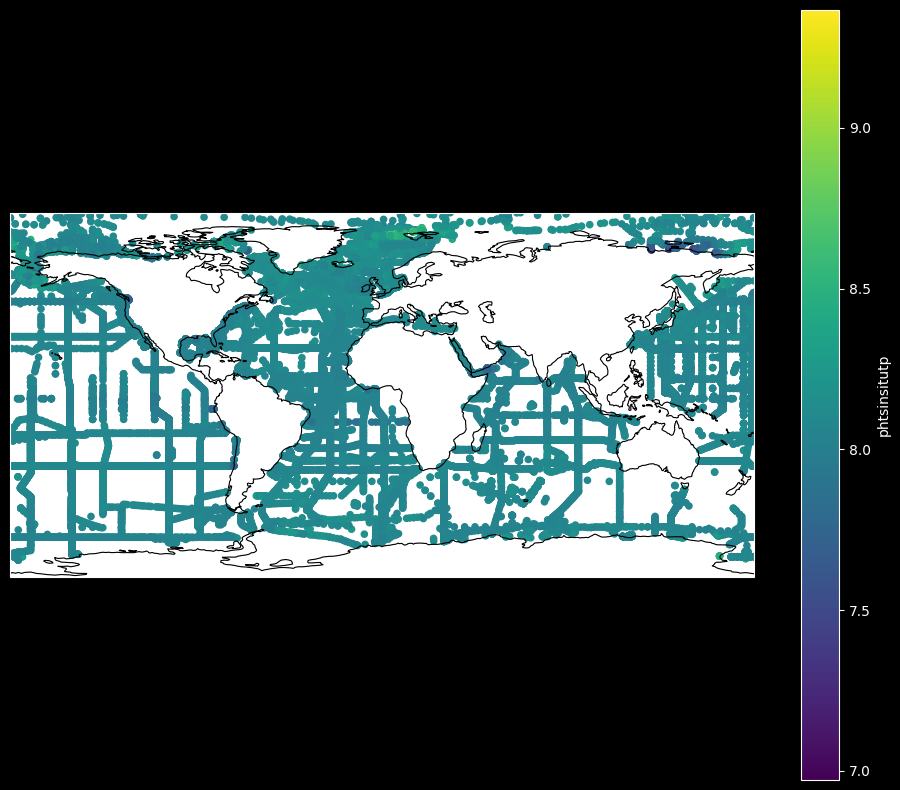

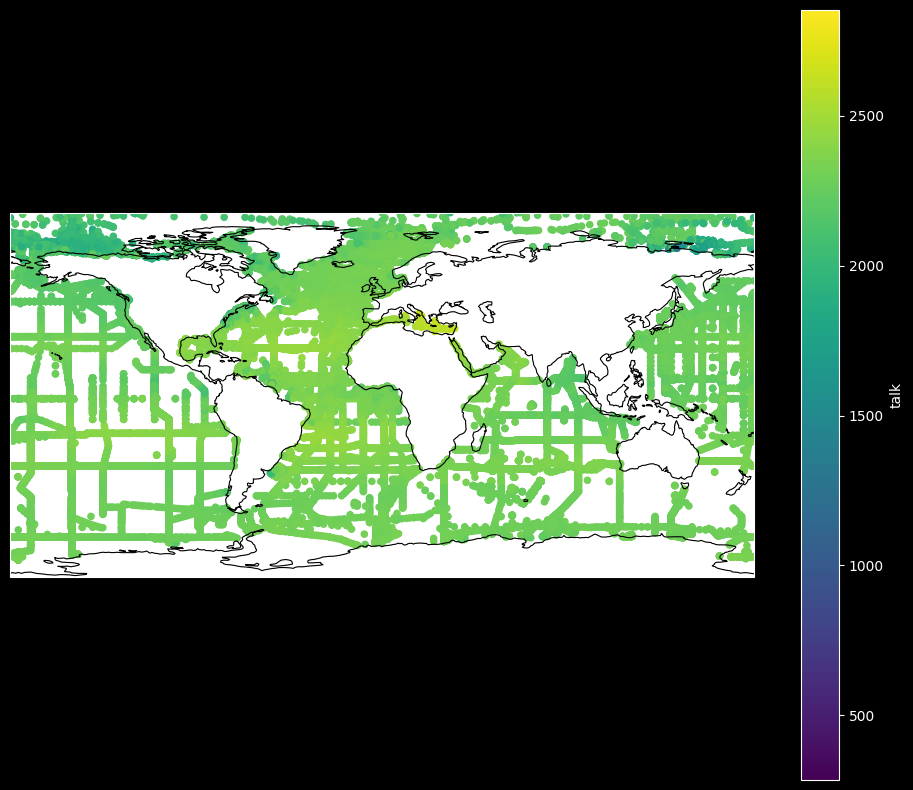

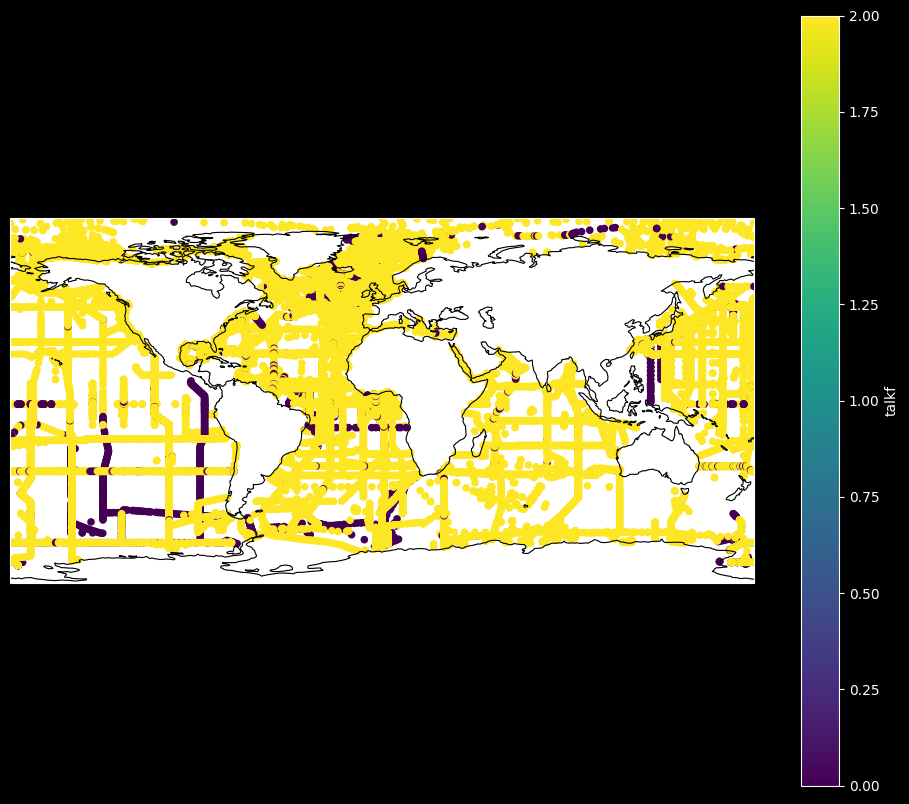

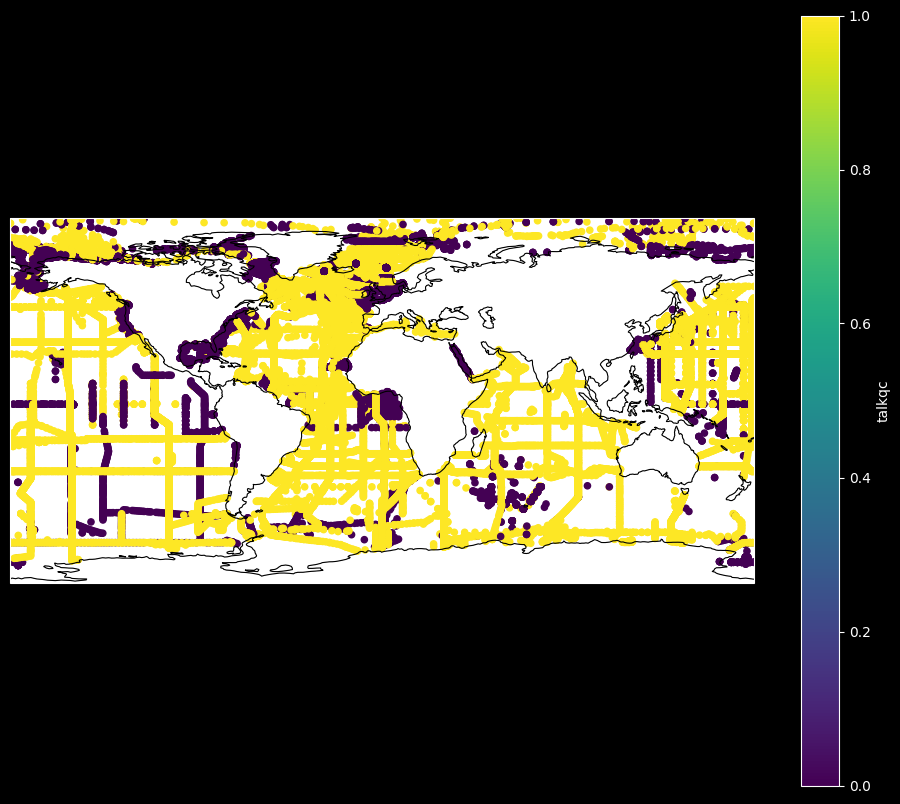

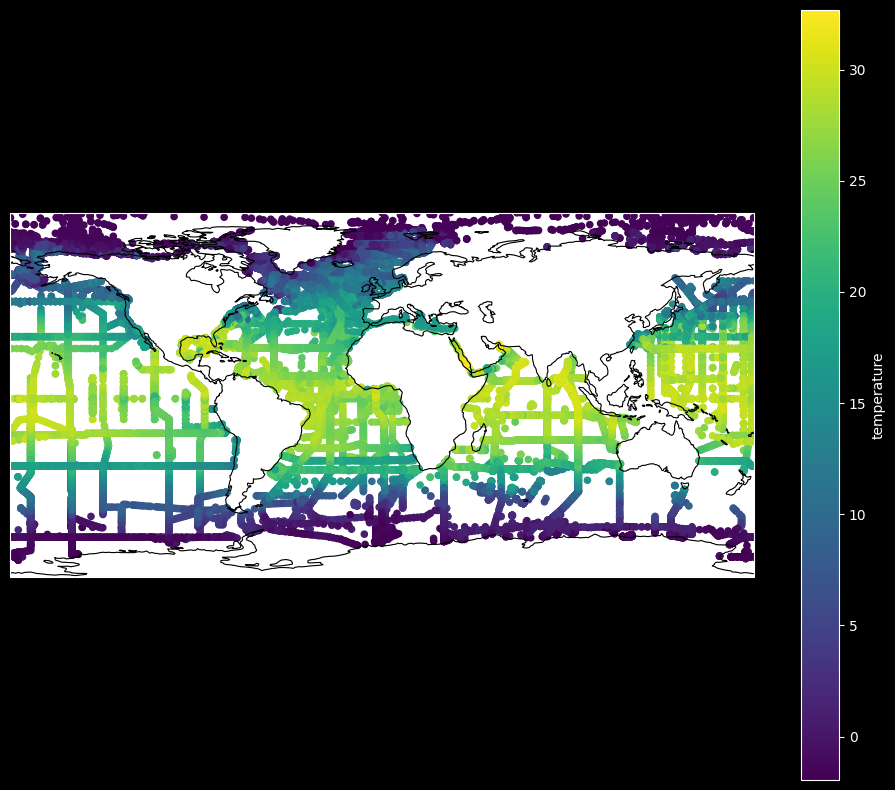

In [ ]:

numerical_columns = df.select_dtypes(include=["int64", "float64"]).columns


ds_name = 'GLODAP'
for variable in datasets_dict[ds_name].vars_list:
    samples_map(df, datasets_dict, ds_name, variable)
    
# # statistics
# df.describe()[cnames[1:21]].T



# # missing values in each columns
# df.isnull().sum()
# #how many features per column are unique
# df.nunique()

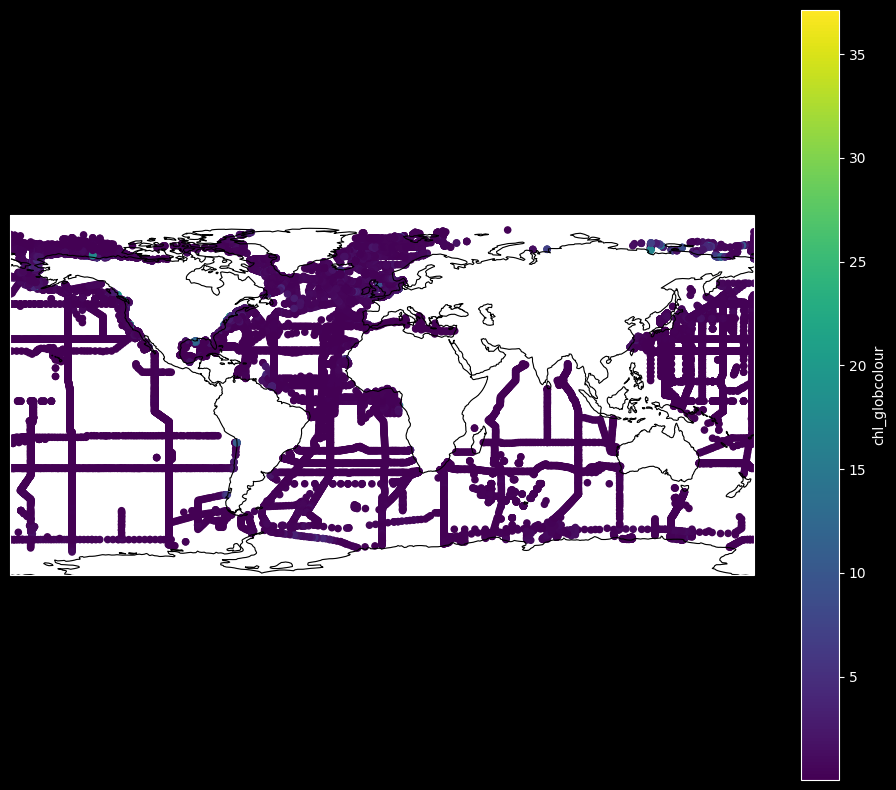

In [9]:
ds_name = 'GLOBCOLOUR'
for variable in datasets_dict[ds_name].vars_list:
    samples_map(df, datasets_dict, ds_name, variable)

In [ ]:





glodap_axes = samples_map(df.lat,df.lon)

# statistics
df.describe()[cnames[1:21]].T